# Data Preparation

## Import Packages and Data

In [141]:
# Standard
import pandas as pd
import numpy as np
import random
import os
import math

# TF and Keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers
from keras import metrics
from keras import losses
from keras import regularizers
from tqdm.keras import TqdmCallback 

# Plots and images
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline
from decimal import Decimal

# Silence TF
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Setting random seeds
random.seed(0)
np.random.seed(0)
tf.random.set_seed(0)

In [142]:
# Reading in the CSVs
X_train = pd.read_csv('X_train.csv')
Y_train = pd.read_csv('Y_train.csv')
X_val = pd.read_csv('X_val.csv')
Y_val = pd.read_csv('Y_val.csv')
X_test = pd.read_csv('X_test.csv')
Y_test = pd.read_csv('Y_test.csv')

In [143]:
# Drop unecessary columns added to the beginning of each DF
for df in [X_train, Y_train, X_val, Y_val, X_test, Y_test]:
    df.drop(columns=['Unnamed: 0'], inplace=True)

## Making One-Hot Encodings and Tensors for Categorical Variables

In [144]:
# Merging train, val, and test sets into one DF to perform the encodings in one batch
X = pd.concat([X_train, X_val, X_test])

# Making the numerical categorical variables into strings - necessary to make the one-hot encodings
X[['opp_diff_ind', 'GW','was_home']] = X[['opp_diff_ind', 'GW','was_home']].astype(str)

In [145]:
# Making categorical variables into sparse one-hot encodings
season_tf = tf.keras.layers.StringLookup(vocabulary=X.season.unique(), output_mode='one_hot')(X.season)

player_team_name_tf = tf.keras.layers.StringLookup(vocabulary=X.player_team_name.unique(), 
                                                         output_mode='one_hot')(X.player_team_name)

opp_team_name_tf = tf.keras.layers.StringLookup(vocabulary=X.opp_team_name.unique(), 
                                                      output_mode='one_hot')(X.opp_team_name)

opp_diff_ind_tf = tf.keras.layers.StringLookup(vocabulary=X.opp_diff_ind.unique(), 
                                                      output_mode='one_hot')(X.opp_diff_ind)

position_tf = tf.keras.layers.StringLookup(vocabulary=X.position.unique(), output_mode='one_hot')(X.position)

gw_tf = tf.keras.layers.StringLookup(vocabulary=X.GW.unique(), output_mode='one_hot')(X.GW)

was_home_tf = tf.keras.layers.StringLookup(vocabulary=X.was_home.unique(), output_mode='one_hot')(X.was_home)

In [146]:
# Getting the correct split sizes to split the tensors into train, val, and test again
split_one = X_train.shape[0]
split_two = X_val.shape[0]
split_three = X_test.shape[0]

# Splitting the encoded tensors into train, val, and test tensors
season_train, season_val, season_test = tf.split(season_tf, [split_one, split_two, split_three], 0)

player_team_name_train, player_team_name_val, player_team_name_test = tf.split(player_team_name_tf, [split_one, split_two, split_three], 0)

opp_team_name_train, opp_team_name_val, opp_team_name_test = tf.split(opp_team_name_tf, [split_one, split_two, split_three], 0)

opp_diff_ind_train, opp_diff_ind_val, opp_diff_ind_test = tf.split(opp_diff_ind_tf, [split_one, split_two, split_three], 0)

position_train, position_val, position_test = tf.split(position_tf, [split_one, split_two, split_three], 0)

gw_train, gw_val, gw_test = tf.split(gw_tf, [split_one, split_two, split_three], 0)

was_home_train, was_home_val, was_home_test = tf.split(was_home_tf, [split_one, split_two, split_three], 0)

## Turning Continuous Variables into Tensors

In [147]:
# Grabbing only the continuous columns we want
# Note: hyperparameter tuning found that lag_3 was the optimal choice between 1, 3, and 5, so we use it here
cols = ['assists_lag_3', 'bonus_lag_3', 'bps_lag_3', 'clean_sheets_lag_3',
       'creativity_lag_3', 'goals_conceded_lag_3', 'goals_scored_lag_3',
       'ict_index_lag_3', 'influence_lag_3', 'minutes_lag_3',
       'own_goals_lag_3', 'penalties_missed_lag_3', 'penalties_saved_lag_3',
       'red_cards_lag_3', 'saves_lag_3', 'selected_lag_3',
       'player_team_score_lag_3', 'opp_team_score_lag_3', 'threat_lag_3',
       'total_points_lag_3', 'value_lag_3', 'yellow_cards_lag_3']

In [148]:
# Making continuous variable tensors
# Naming convention: "contin" stands for "continuous" and tf signifies that these are tensors
X_train_contin_tf = tf.convert_to_tensor(X_train[cols])
X_val_contin_tf = tf.convert_to_tensor(X_val[cols])
X_test_contin_tf = tf.convert_to_tensor(X_test[cols])

## Making Final X and Y input Tensors

In [149]:
# Making lists of train, val, and test tensors to combine
# Note: using this method (rather than pytorch) because pytorch kept crashing my kernel
X_train_tensor_list = [season_train, player_team_name_train, opp_team_name_train, opp_diff_ind_train, 
                       position_train, gw_train, was_home_train, X_train_contin_tf]

X_val_tensor_list = [season_val, player_team_name_val, opp_team_name_val, opp_diff_ind_val, 
                     position_val, gw_val, was_home_val, X_val_contin_tf]

X_test_tensor_list = [season_test, player_team_name_test, opp_team_name_test, opp_diff_ind_test, 
                      position_test, gw_test, was_home_test, X_test_contin_tf]

In [150]:
# Concatenating input tensors
X_train_tf = tf.keras.layers.Concatenate(axis=1)(X_train_tensor_list)
X_val_tf = tf.keras.layers.Concatenate(axis=1)(X_val_tensor_list)
X_test_tf = tf.keras.layers.Concatenate(axis=1)(X_test_tensor_list)

In [151]:
# Making target tensors
Y_train_tf = tf.convert_to_tensor(Y_train)
Y_val_tf = tf.convert_to_tensor(Y_val)
Y_test_tf = tf.convert_to_tensor(Y_test)

# Making a Baseline

In [152]:
# Setting up necessary functions

# Making a vector of predictions as long as the actuals
def pred_vect(true_values, prediction=2):
    predictions = []
    count = 0
    pred = prediction # Can pass baseline or 2
    while count < len(true_values):
        predictions.append(pred)
        count += 1
        
    return predictions

# Defining loss functions
def MSE(true_values, predicted_values):
    """Return the MSE between true_values and predicted values."""
    tot = 0
    count = 0
    
    # Calculating the SE for each data point
    while count < len(true_values):
        tot += (true_values[count] - predicted_values[count])**2
        count += 1
    
    # Returning the MSE
    return tot / len(true_values)

def RMSE(true_values, predicted_values):
    """Return the RMSE between true_values and predicted values."""
    tot = 0
    count = 0
    
    # Calculating the SE for each data point
    while count < len(true_values):
        tot += (true_values[count] - predicted_values[count])**2
        count += 1
    
    # Returning the RMSE
    return math.sqrt(tot / len(true_values))

def MAE(true_values, predicted_values):
    """Return the MAE between true_values and predicted values."""
    tot = 0
    count = 0
    
    # Calculating the SE for each data point
    while count < len(true_values):
        tot += abs(true_values[count] - predicted_values[count])
        count += 1
    
    # Returning the MAE
    return tot / len(true_values)

In [153]:
# Creating a baseline with the average value
baseline = Y_train['total_points'].mean()

In [154]:
true = np.array(Y_test['total_points'])
pred = np.array(pred_vect(Y_test['total_points'],baseline))

print(f'MSE is {round(MSE(true, pred),3)}')
print(f'RMSE is {round(RMSE(true, pred),3)}')
print(f'MAE is {round(MAE(true, pred),3)}')

MSE is 5.573
RMSE is 2.361
MAE is 1.595


# Defining Plotting Function

In [155]:
def mse_mae_plots(history):
    '''
    Takes in history from model fitting and plots loss and MAE by epoch for both train and val
    '''
    hist = history.history
    x_arr = np.arange(len(hist['loss'])) + 1
    
    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(x_arr, hist['loss'], '-o', color='darkturquoise', label='Train loss')
    ax.plot(x_arr, hist['val_loss'], '-s', color='mediumvioletred', label='Validation loss')
    plt.axhline(y = MSE(true, pred), color = 'limegreen', linestyle = '-') # Adding a horizontal line for baseline MSE
    ax.legend(fontsize=12)
    ax.set_xlabel('Epoch', size=12)
    ax.set_ylabel('Mean Squared Error (MSE)', size=12)
    ax.set_title('MSE by Epoch')

    ax = fig.add_subplot(1, 2, 2)
    ax.plot(x_arr, hist['mean_absolute_error'], '-o', color='darkturquoise', label='Train MAE')
    ax.plot(x_arr, hist['val_mean_absolute_error'], '-s', color='mediumvioletred', label='Validation MAE')
    plt.axhline(y = MAE(true, pred), color = 'limegreen', linestyle = '-') # Adding a horizontal line for baseline MAE
    ax.legend(fontsize=12)
    ax.set_xlabel('Epoch', size=12)
    ax.set_ylabel('Mean Absolute Error (MAE)', size=12)
    ax.set_title('MAE by Epoch')

In [156]:
# Making a DF in which to store results
lin_reg_results = pd.DataFrame(columns=['learning_rate', 'epoch_count', 'optimizer', 'decay_steps', 
                                        'decay_rate', 'lr_schedule', 'train_loss', 'train_mae','val_loss','val_mae'])

In [157]:
# Defining a function to create linear regression models
def make_lin_reg_model(epoch_count=20, learning_rate=0.000075, optimizer='Adam', decay_steps=10000, decay_rate=0.95, lr_sched='no'):

    ############################################################################################## 1
    # Preparing the data
    num_features = X_train_tf.shape[1]

    ############################################################################################## 2
    # Building the model
    tf.keras.backend.clear_session()
    model = tf.keras.Sequential()
    
    # Create input layer
    model.add(tf.keras.Input(shape=(num_features,), name='Input'
              ))
    
    # Create output layer
    model.add(tf.keras.layers.Dense(
              activation = None,    # linear activation
              units = 1,            
              use_bias = True             
              ))
    
    # Set a learning rate schedule
    if lr_sched == 'yes':
        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=learning_rate,
            decay_steps=decay_steps,
            decay_rate=decay_rate)
    else:
        lr_schedule = learning_rate
    
    # Set optimizer
    if optimizer == 'SGD':
      opt = tf.keras.optimizers.SGD(learning_rate=lr_schedule)
    elif optimizer == 'Adam':
      opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
    else:
      raise 'Unsupported optimizer: %s' %optimizer

    ############################################################################################## 3
    # Compiling the model
    model.compile(
        optimizer=opt,
        loss=losses.MeanSquaredError(),
        metrics=[metrics.mse,
                 metrics.RootMeanSquaredError(),
                 metrics.mae]
        )

    ############################################################################################## 4
    # Fitting the model
    history = model.fit(
        x = X_train_tf,
        y = Y_train_tf,
        epochs = epoch_count,
        validation_data = (X_val_tf, Y_val_tf),
        verbose=False,
        callbacks=[TqdmCallback()]
        )

    ############################################################################################## 5
    # Plotting the results
    mse_mae_plots(history)

    ############################################################################################## 6
    # Appending results to the results DF

    # Pulling this in to get loss and accuracy
    hist = history.history
    
    new_row = {'learning_rate': learning_rate, 'epoch_count': epoch_count, 'optimizer': optimizer, 'lr_schedule':lr_sched, 
               'decay_steps': decay_steps, 'decay_rate': decay_rate, 'train_loss': hist['loss'][-1], 
               'train_mae': hist['mean_absolute_error'][-1], 'val_loss': hist['val_loss'][-1], 
               'val_mae': hist['val_mean_absolute_error'][-1]}
    
    lin_reg_results.loc[len(lin_reg_results)] = new_row

    ############################################################################################## 6
    # Evaluating the model
    
    results = model.evaluate(X_test_tf, Y_test_tf)
    print(f'MSE is {round(results[1],3)}')
    print(f'RMSE is {round(results[2],3)}')
    print(f'MAE is {round(results[3],3)}')

## Learning rates

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

829/829 [==============================] - 0s 536us/step - loss: 4.1662 - mean_squared_error: 4.1662 - root_mean_squared_error: 2.0411 - mean_absolute_error: 1.0885
MSE is 4.166
RMSE is 2.041
MAE is 1.088


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

829/829 [==============================] - 0s 552us/step - loss: 4.0840 - mean_squared_error: 4.0840 - root_mean_squared_error: 2.0209 - mean_absolute_error: 1.0762
MSE is 4.084
RMSE is 2.021
MAE is 1.076


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

829/829 [==============================] - 0s 526us/step - loss: 4.1240 - mean_squared_error: 4.1240 - root_mean_squared_error: 2.0308 - mean_absolute_error: 1.0641
MSE is 4.124
RMSE is 2.031
MAE is 1.064


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

829/829 [==============================] - 0s 534us/step - loss: 4.3907 - mean_squared_error: 4.3907 - root_mean_squared_error: 2.0954 - mean_absolute_error: 1.0831
MSE is 4.391
RMSE is 2.095
MAE is 1.083


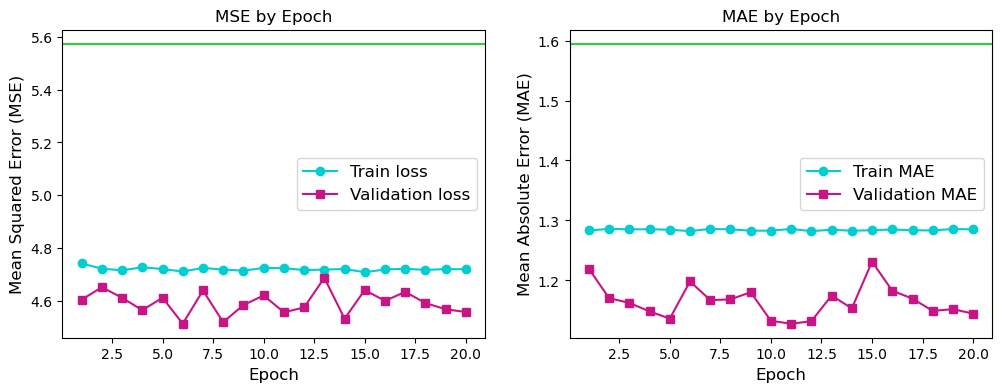

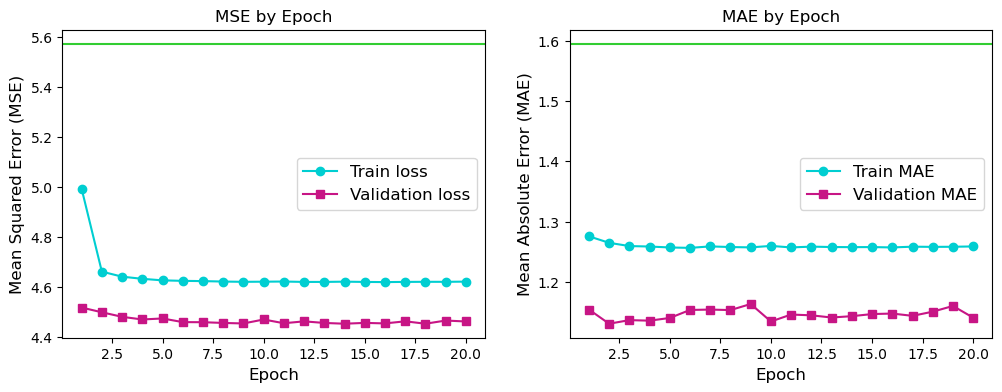

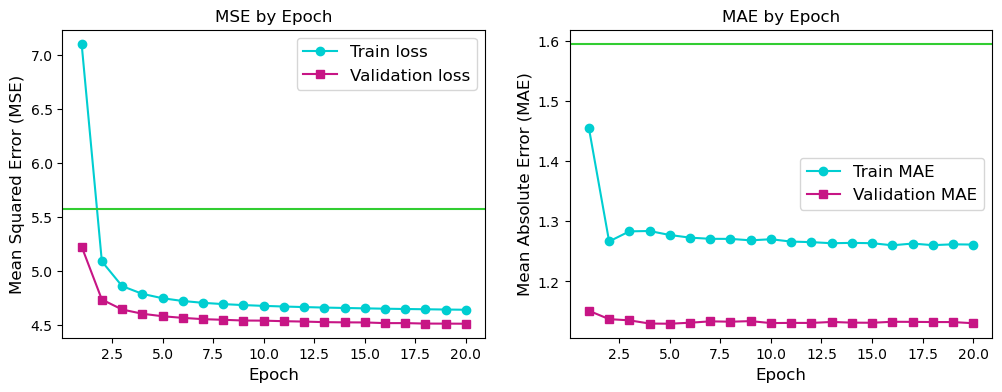

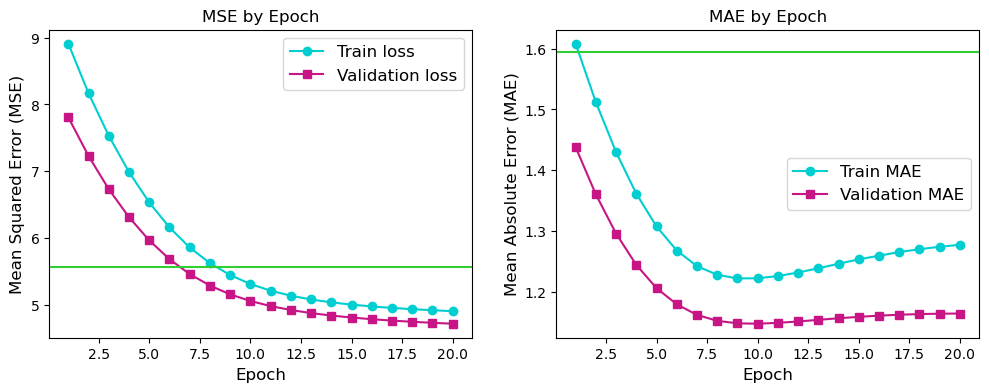

In [158]:
for rate in [0.01, 0.001, 0.0001, 0.00001]:
    make_lin_reg_model(learning_rate=rate)

In [159]:
lin_reg_results.sort_values('train_loss')

,learning_rate,epoch_count,optimizer,decay_steps,decay_rate,lr_schedule,train_loss,train_mae,val_loss,val_mae
1,0.00100,20,Adam,10000,0.95,no,4.621835,1.258900,4.462417,1.140904
2,0.00010,20,Adam,10000,0.95,no,4.639487,1.261238,4.509956,1.130615
0,0.01000,20,Adam,10000,0.95,no,4.720510,1.285123,4.558776,1.144593
3,0.00001,20,Adam,10000,0.95,no,4.905275,1.277829,4.717481,1.164927


In [160]:
# Conclusion: 0.0001 has the best learning curve (minimizes underfitting)

## Learning rates - round 2
Closing in on chosen value

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

829/829 [==============================] - 0s 536us/step - loss: 4.0163 - mean_squared_error: 4.0163 - root_mean_squared_error: 2.0041 - mean_absolute_error: 1.0976
MSE is 4.016
RMSE is 2.004
MAE is 1.098


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

829/829 [==============================] - 0s 575us/step - loss: 4.0692 - mean_squared_error: 4.0692 - root_mean_squared_error: 2.0172 - mean_absolute_error: 1.0632
MSE is 4.069
RMSE is 2.017
MAE is 1.063


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

829/829 [==============================] - 0s 549us/step - loss: 4.2111 - mean_squared_error: 4.2111 - root_mean_squared_error: 2.0521 - mean_absolute_error: 1.0901
MSE is 4.211
RMSE is 2.052
MAE is 1.09


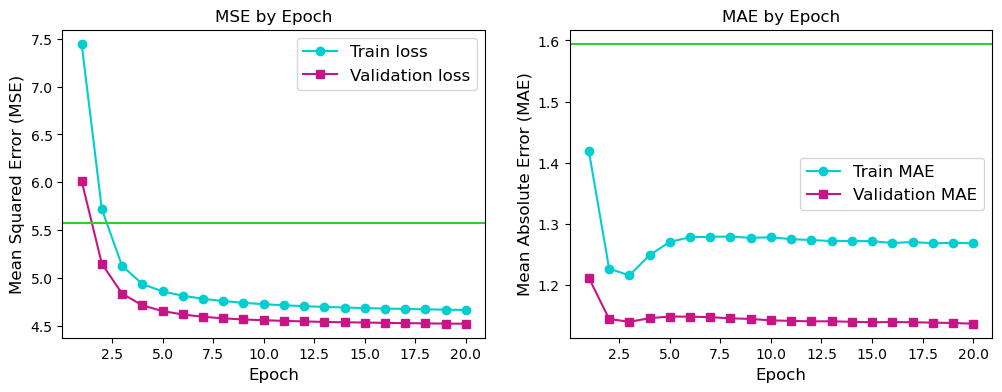

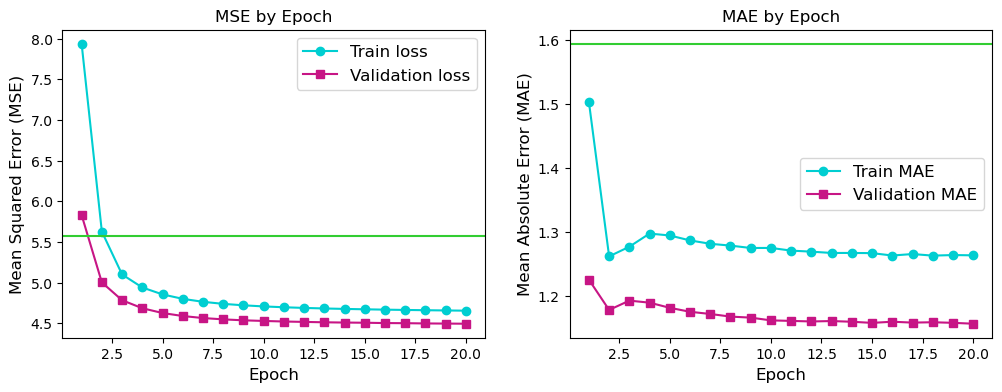

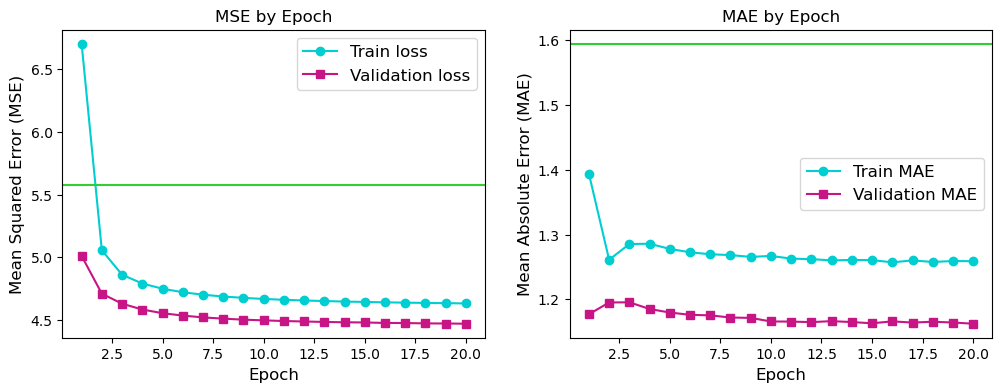

In [161]:
for rate in [0.00005, 0.000075, 0.0001]:
    make_lin_reg_model(learning_rate=rate)

In [163]:
# Conclusion: 0.0005 has the lowest train loss

## Optimizer

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

829/829 [==============================] - 1s 618us/step - loss: 4.0629 - mean_squared_error: 4.0629 - root_mean_squared_error: 2.0157 - mean_absolute_error: 1.0717
MSE is 4.063
RMSE is 2.016
MAE is 1.072


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

829/829 [==============================] - 1s 611us/step - loss: 3.9972 - mean_squared_error: 3.9972 - root_mean_squared_error: 1.9993 - mean_absolute_error: 1.1270
MSE is 3.997
RMSE is 1.999
MAE is 1.127


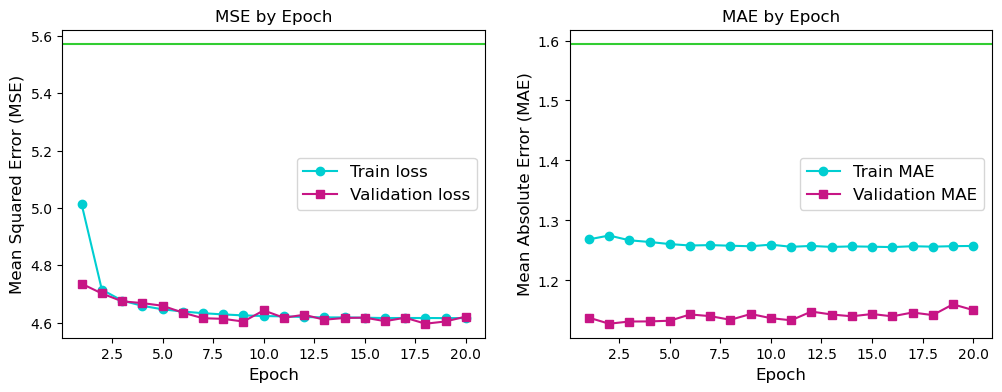

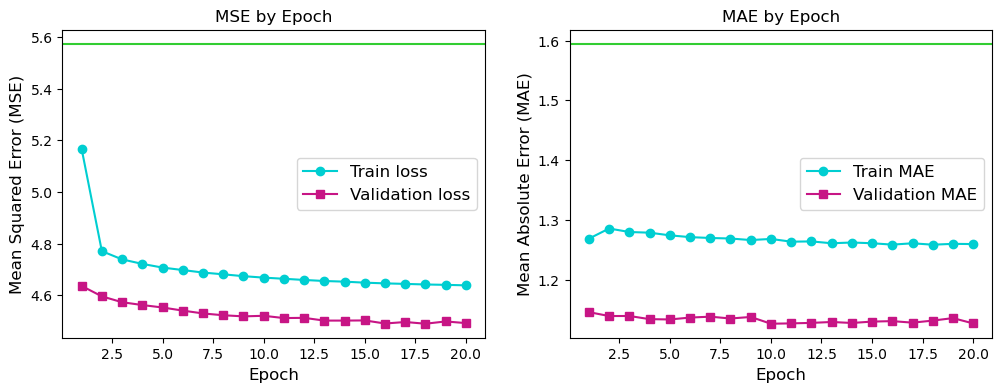

In [164]:
for opt in ['Adam','SGD']:
    make_lin_reg_model(learning_rate=0.0005, optimizer=opt)

In [166]:
# Conclusion: they are similar, but Adam wins out

## Learning rate schedule

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

829/829 [==============================] - 0s 538us/step - loss: 4.0609 - mean_squared_error: 4.0609 - root_mean_squared_error: 2.0152 - mean_absolute_error: 1.0821
MSE is 4.061
RMSE is 2.015
MAE is 1.082


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

829/829 [==============================] - 0s 582us/step - loss: 4.0308 - mean_squared_error: 4.0308 - root_mean_squared_error: 2.0077 - mean_absolute_error: 1.0850
MSE is 4.031
RMSE is 2.008
MAE is 1.085


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

829/829 [==============================] - 0s 498us/step - loss: 4.1264 - mean_squared_error: 4.1264 - root_mean_squared_error: 2.0314 - mean_absolute_error: 1.0714
MSE is 4.126
RMSE is 2.031
MAE is 1.071


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

829/829 [==============================] - 0s 575us/step - loss: 4.0155 - mean_squared_error: 4.0155 - root_mean_squared_error: 2.0039 - mean_absolute_error: 1.0695
MSE is 4.016
RMSE is 2.004
MAE is 1.07


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

829/829 [==============================] - 0s 503us/step - loss: 4.0451 - mean_squared_error: 4.0451 - root_mean_squared_error: 2.0112 - mean_absolute_error: 1.0660
MSE is 4.045
RMSE is 2.011
MAE is 1.066


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

829/829 [==============================] - 0s 506us/step - loss: 4.0224 - mean_squared_error: 4.0224 - root_mean_squared_error: 2.0056 - mean_absolute_error: 1.0719
MSE is 4.022
RMSE is 2.006
MAE is 1.072


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

829/829 [==============================] - 0s 497us/step - loss: 4.2015 - mean_squared_error: 4.2015 - root_mean_squared_error: 2.0498 - mean_absolute_error: 1.1116
MSE is 4.202
RMSE is 2.05
MAE is 1.112


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

829/829 [==============================] - 0s 508us/step - loss: 4.0233 - mean_squared_error: 4.0233 - root_mean_squared_error: 2.0058 - mean_absolute_error: 1.0707
MSE is 4.023
RMSE is 2.006
MAE is 1.071


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

829/829 [==============================] - 0s 545us/step - loss: 4.1534 - mean_squared_error: 4.1534 - root_mean_squared_error: 2.0380 - mean_absolute_error: 1.0952
MSE is 4.153
RMSE is 2.038
MAE is 1.095


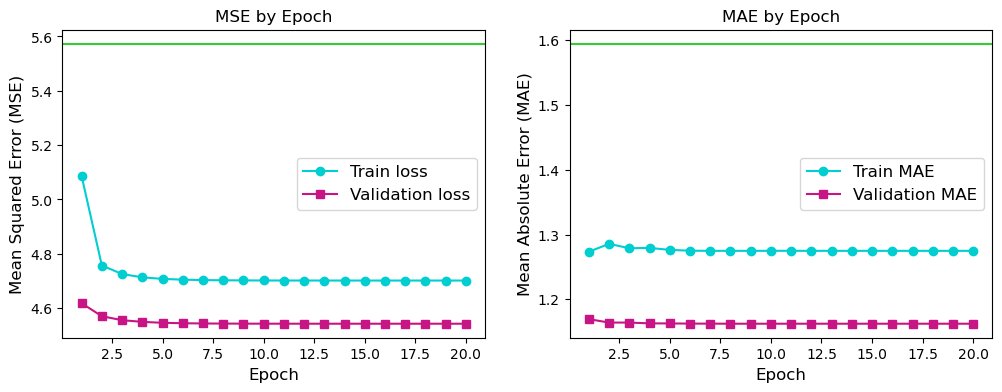

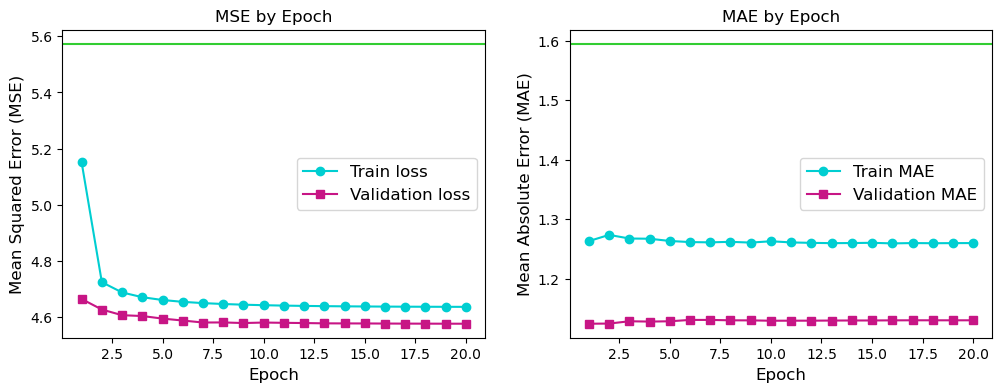

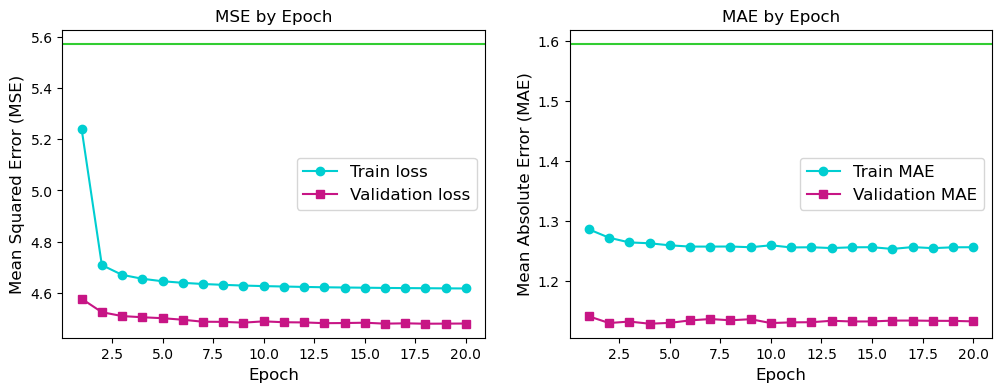

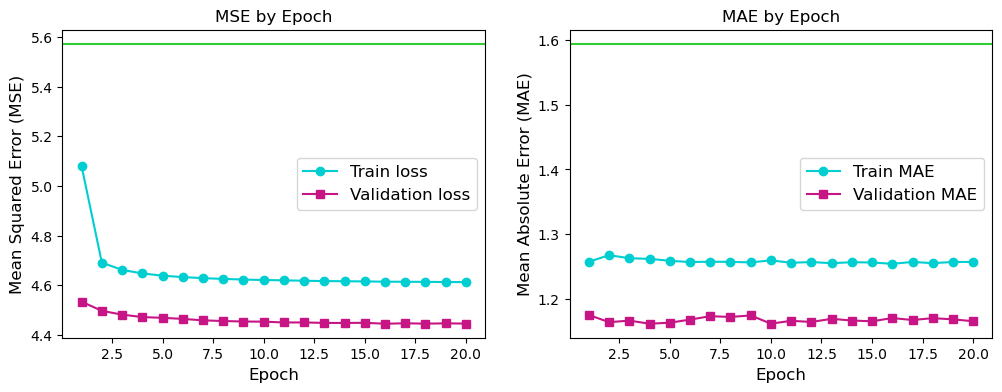

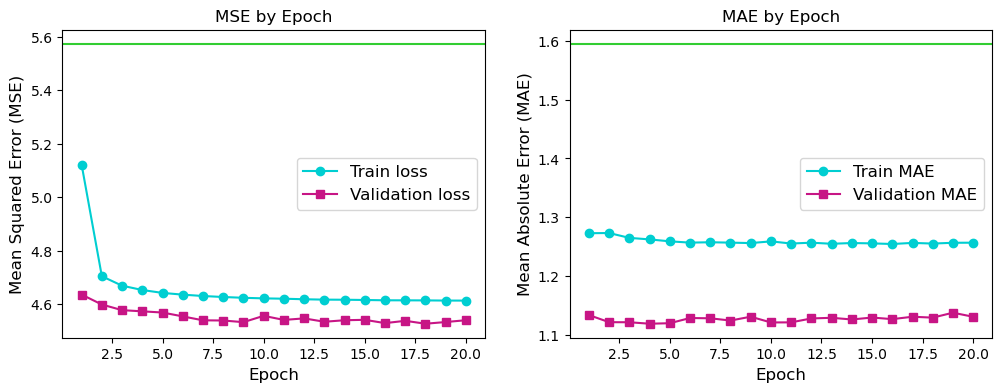

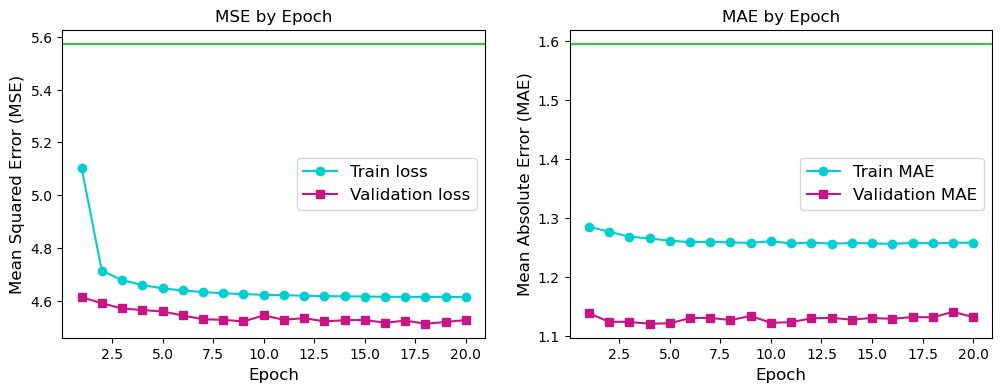

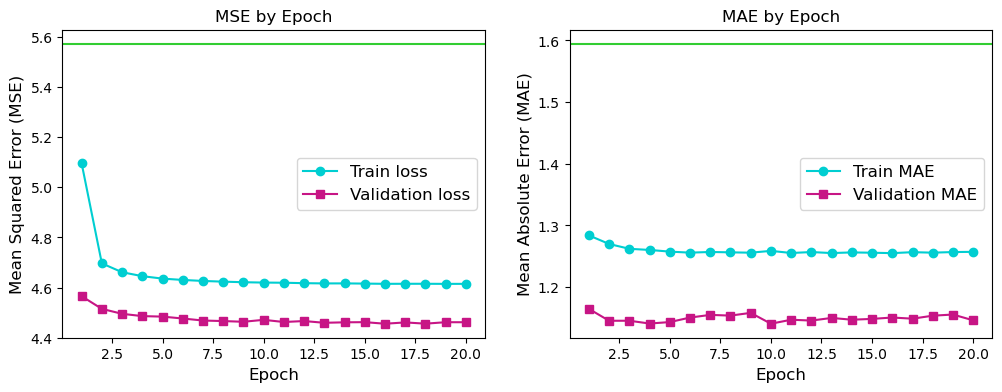

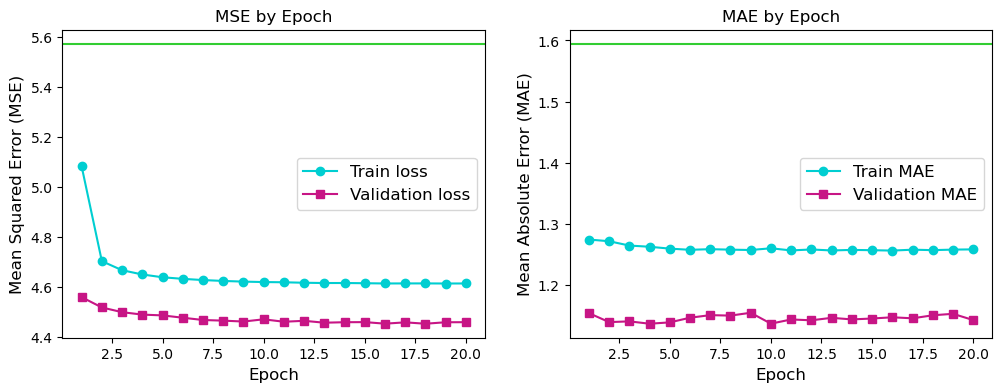

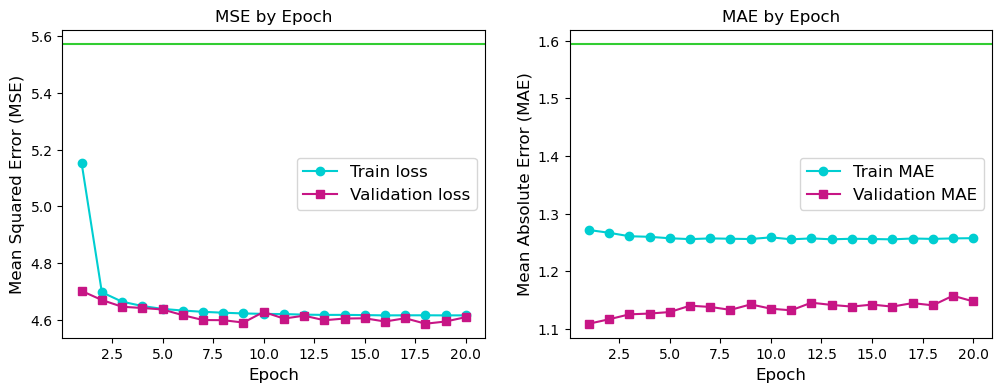

In [167]:
for step in [1000, 10000, 100000]:
    for rate in [0.75, 0.9, 0.95]:
        make_lin_reg_model(learning_rate=0.0005, optimizer='Adam', decay_steps=step, decay_rate=rate, lr_sched='yes')

In [169]:
# Conclusion: 10k steps with a decay rate of 0.9 wins

## Epochs

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

829/829 [==============================] - 0s 510us/step - loss: 4.0965 - mean_squared_error: 4.0965 - root_mean_squared_error: 2.0240 - mean_absolute_error: 1.0763
MSE is 4.096
RMSE is 2.024
MAE is 1.076


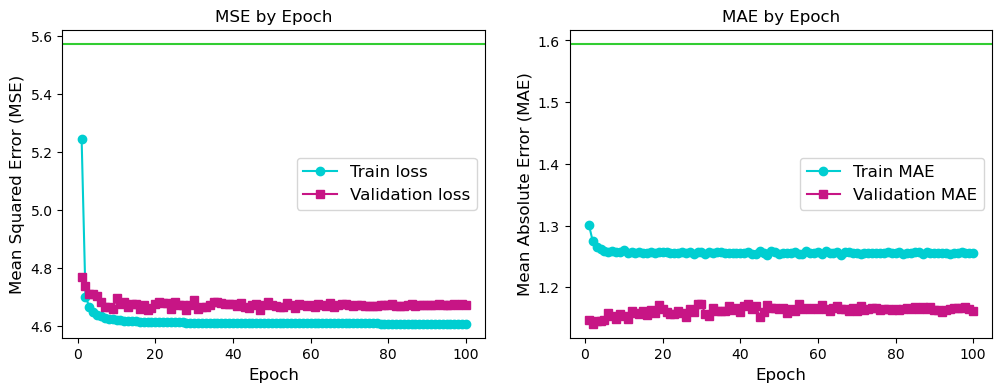

In [170]:
make_lin_reg_model(learning_rate=0.0005, optimizer='Adam', epoch_count=100, lr_sched='yes', decay_steps=10000, decay_rate=0.9)

In [171]:
# Conclusion: no need to go past 20 epochs

# Making a FFNN

In [172]:
# Making a DF in which to store results
results = pd.DataFrame(columns=['learning_rate', 'epoch_count', 'hidden_layer_count', 'hidden_layer_size_s', 
                                'hl_act_func', 'dropout_rate', 'oput_act_func', 'optimizer', 'lr_schedule',
                                'decay_steps', 'decay_rate', 'train_loss', 'train_mae','val_loss','val_mae'])

In [173]:
# Setup for testing different configurations

def create_nn(learning_rate=0.00001, epoch_count=200, hidden_layer_sizes=[150, 75], 
              hl_act_func='relu', dropout_rate=0.1, oput_act_func='relu', optimizer='Adam', plot_flag=True,
              verbosity_flag=False, lr_sched='yes', decay_steps=10000, decay_rate=0.95):
    
    ############################################################################################## 1
    # Getting number of features
    num_features = X_train_tf.shape[1]

    ############################################################################################## 2
    # Building the model
    tf.keras.backend.clear_session()
    model = tf.keras.Sequential()

    # Create input layer
    model.add(tf.keras.Input(shape=(num_features,), name='Input'
              ))

    # Create hidden layers
    for i, hidden_layer_size in enumerate(hidden_layer_sizes):
      model.add(tf.keras.layers.Dense(units=hidden_layer_size,
                                     activation=hl_act_func,
                                     name = f'Hidden_{i+1}'))
    
      # Create dropout after each hidden layer
      model.add(tf.keras.layers.Dropout(rate=dropout_rate, name=f'Dropout_{i+1}') # Need to make dropout rate variable
              )
    
    
    # Create output layer
    model.add(tf.keras.layers.Dense(
              activation = oput_act_func, 
              units = 1,                
              use_bias = True
              ))

    # Set a learning rate schedule
    if lr_sched == 'yes':
        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=learning_rate,
            decay_steps=decay_steps,
            decay_rate=decay_rate)
    else:
        lr_schedule = learning_rate
    
    # Set optimizer
    if optimizer == 'SGD':
      opt = tf.keras.optimizers.SGD(learning_rate=lr_schedule)
    elif optimizer == 'Adam':
      opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
    else:
      raise 'Unsupported optimizer: %s' %optimizer

    ############################################################################################## 3
    # Compiling the model
    model.compile(
        optimizer=opt,
        loss='mse',
        metrics=[metrics.mse,
                 metrics.RootMeanSquaredError(),
                 metrics.mae]
        )

    ############################################################################################## 4
    # Fitting the model
    history = model.fit(
        x = X_train_tf,
        y = Y_train_tf,
        epochs = epoch_count,
        validation_data = (X_val_tf, Y_val_tf),
        verbose=verbosity_flag,
        callbacks=[TqdmCallback()]
    )

    ############################################################################################## 5
    # Displaying learning rates
    if plot_flag == True:
        mse_mae_plots(history)

    ############################################################################################## 6
    # Appending results to the results DF

    # Pulling this in to get loss and accuracy
    hist = history.history
    
    new_row = {'learning_rate': learning_rate, 'epoch_count': epoch_count, 'optimizer': optimizer, 'lr_schedule':lr_sched, 
               'decay_steps': decay_steps, 'decay_rate': decay_rate, 'hidden_layer_count': len(hidden_layer_sizes), 
               'hidden_layer_size_s': hidden_layer_sizes, 'hl_act_func': hl_act_func, 'dropout_rate':dropout_rate, 
               'oput_act_func': oput_act_func,'optimizer': optimizer,'train_loss': hist['loss'][-1], 
               'train_mae': hist['mean_absolute_error'][-1], 'val_loss': hist['val_loss'][-1], 
               'val_mae': hist['val_mean_absolute_error'][-1]}
    
    results.loc[len(results)] = new_row

    return history

    ############################################################################################## 7
    # Evaluating the model
    #ffnn_results = model.evaluate(X_test_tf, Y_test_tf)
    #print(f'MSE is {round(ffnn_results[1],3)}')
    #print(f'RMSE is {round(ffnn_results[2],3)}')
    #print(f'MAE is {round(ffnn_results[3],3)}')

# Charts for slide

### Hidden layers

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

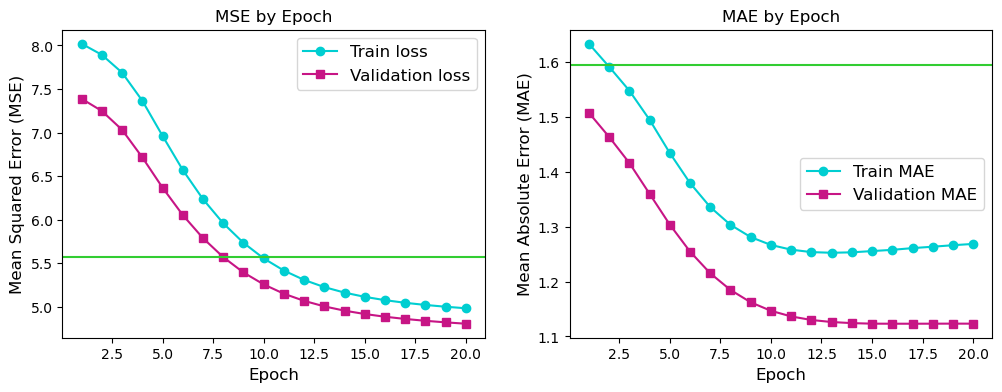

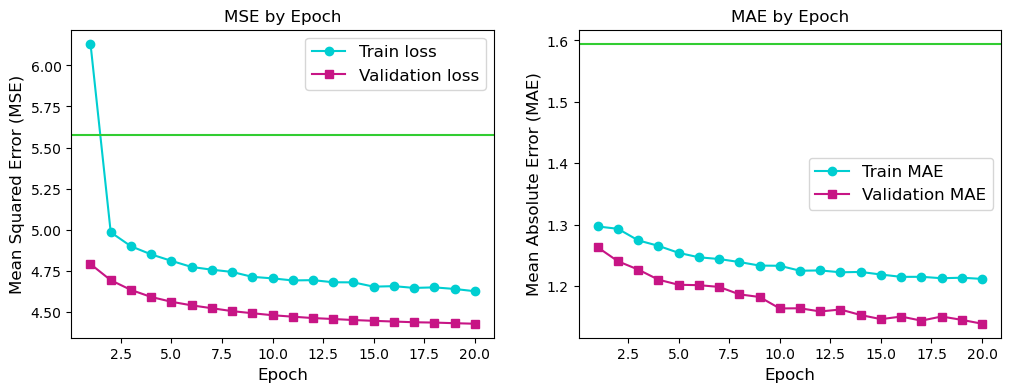

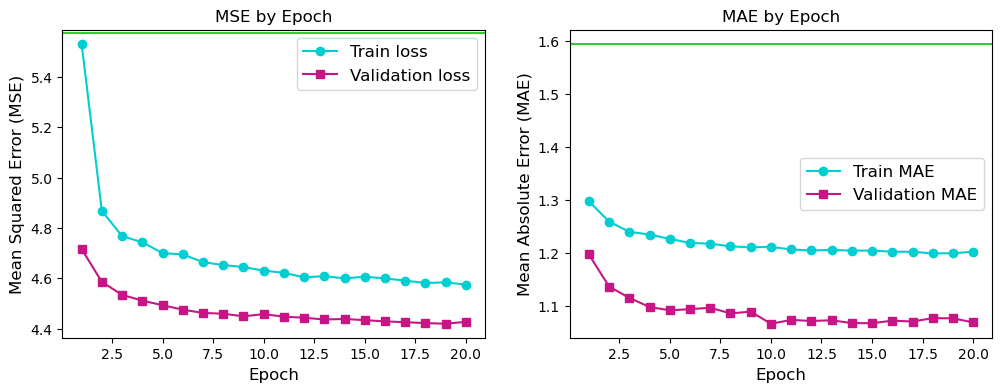

In [174]:
# Lowest LR
hist1 = create_nn(epoch_count=20, hidden_layer_sizes=[]).history
lr1_arr = np.arange(len(hist1['loss'])) + 1

# Middle LR
hist2 = create_nn(epoch_count=20, hidden_layer_sizes=[150, 75]).history
lr2_arr = np.arange(len(hist2['loss'])) + 1

# Highest LR
hist3 = create_nn(epoch_count=20, hidden_layer_sizes=[300, 150, 75]).history
lr3_arr = np.arange(len(hist3['loss'])) + 1

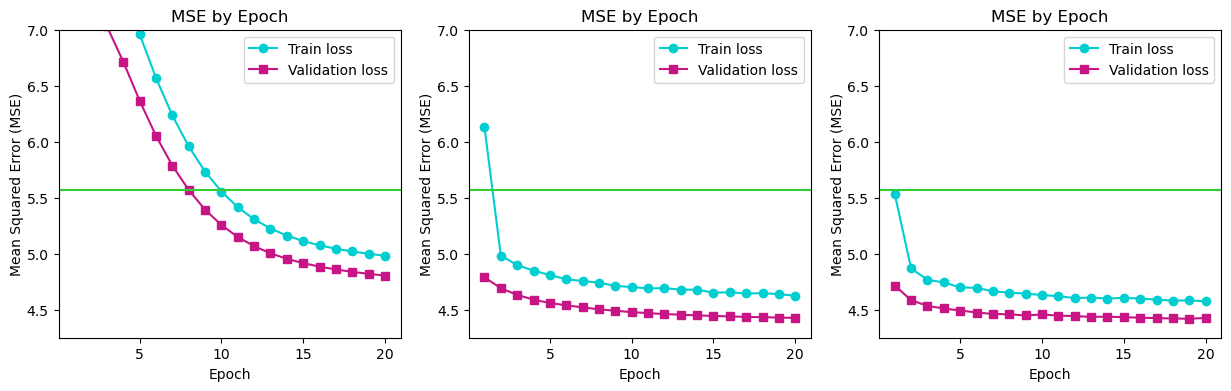

In [175]:
fig = plt.figure(figsize=(15, 4))
count = 1

for arr, hist in zip([lr1_arr, lr2_arr, lr3_arr], [hist1, hist2, hist3]):
    ax = fig.add_subplot(1, 3, count)
    ax.plot(arr, hist['loss'], '-o', color='darkturquoise', label='Train loss')
    ax.plot(arr, hist['val_loss'], '-s', color='mediumvioletred', label='Validation loss')
    plt.axhline(y = MSE(true, pred), color = 'limegreen', linestyle = '-') # Adding a horizontal line for baseline MSE
    ax.legend(fontsize=10)
    ax.set_xlabel('Epoch', size=10)
    ax.set_ylabel('Mean Squared Error (MSE)', size=10, labelpad=2)
    ax.set_title('MSE by Epoch')
    ax.set_ylim([4.25, 7])
    count += 1

### Learning Rate

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

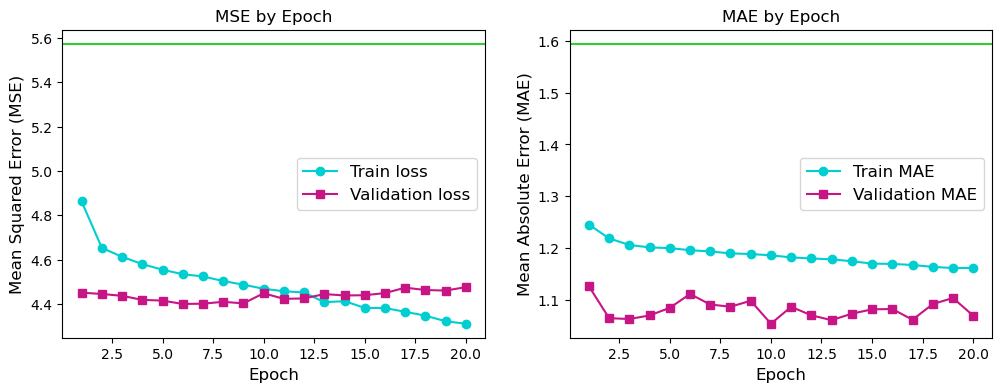

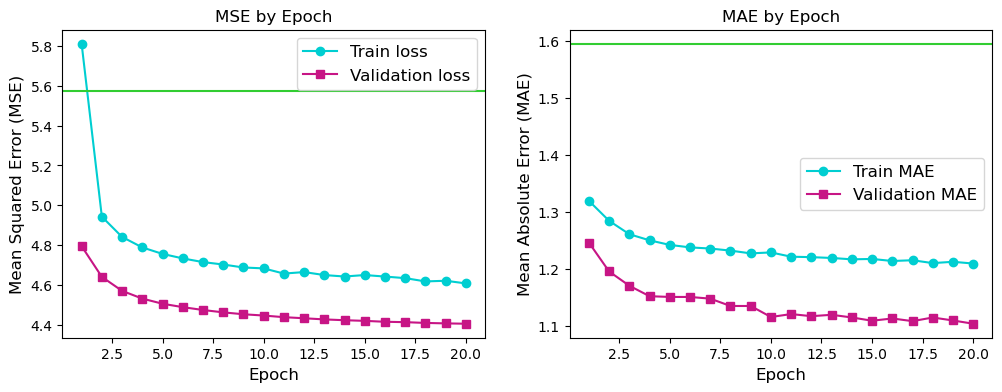

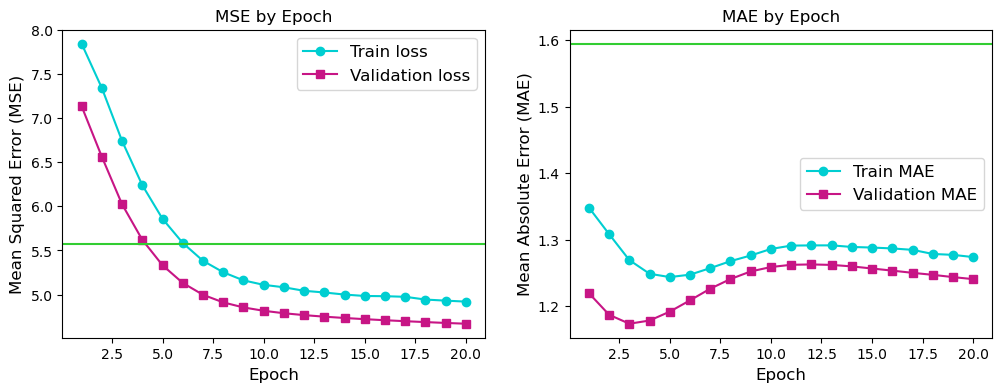

In [176]:
# Lowest LR
hist1 = create_nn(epoch_count=20, learning_rate=0.0001).history
lr1_arr = np.arange(len(hist1['loss'])) + 1

# Middle LR
hist2 = create_nn(epoch_count=20, learning_rate=0.00001).history
lr2_arr = np.arange(len(hist2['loss'])) + 1

# Highest LR
hist3 = create_nn(epoch_count=20, learning_rate=0.000001).history
lr3_arr = np.arange(len(hist3['loss'])) + 1

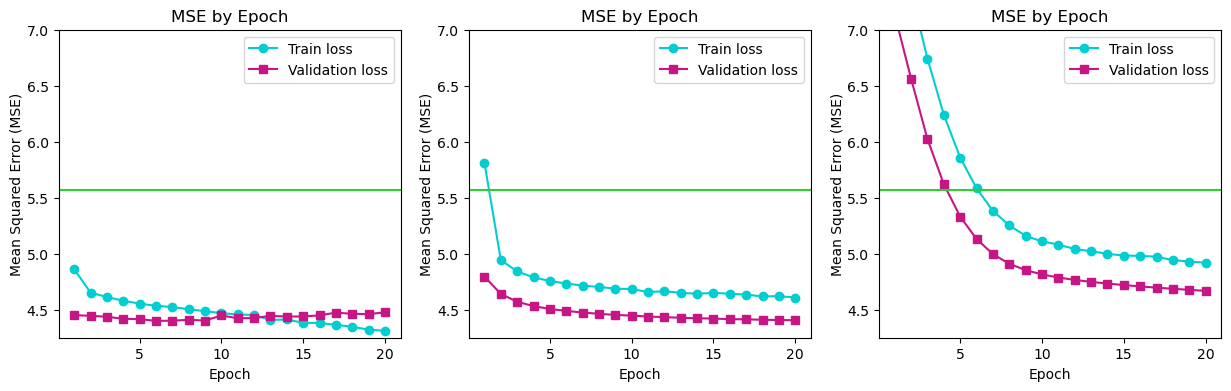

In [177]:
fig = plt.figure(figsize=(15, 4))
count = 1

for arr, hist in zip([lr1_arr, lr2_arr, lr3_arr], [hist1, hist2, hist3]):
    ax = fig.add_subplot(1, 3, count)
    ax.plot(arr, hist['loss'], '-o', color='darkturquoise', label='Train loss')
    ax.plot(arr, hist['val_loss'], '-s', color='mediumvioletred', label='Validation loss')
    plt.axhline(y = MSE(true, pred), color = 'limegreen', linestyle = '-') # Adding a horizontal line for baseline MSE
    ax.legend(fontsize=10)
    ax.set_xlabel('Epoch', size=10)
    ax.set_ylabel('Mean Squared Error (MSE)', size=10, labelpad=2)
    ax.set_title('MSE by Epoch')
    ax.set_ylim([4.25, 7])
    count += 1

In [178]:
# Turning numbers into scientific notation
# Can remove at the end - this is for making the slides
'%.2E' % Decimal('0.00001')

'1.00E-05'

### Epoch Count

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

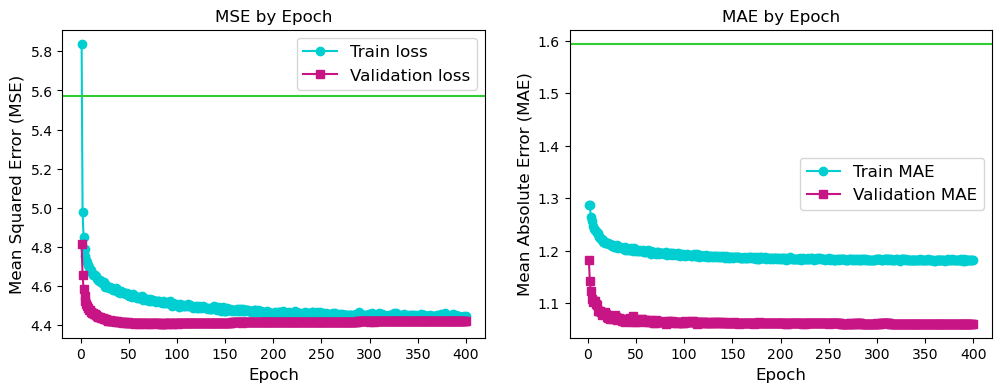

In [179]:
create_nn(epoch_count=400)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

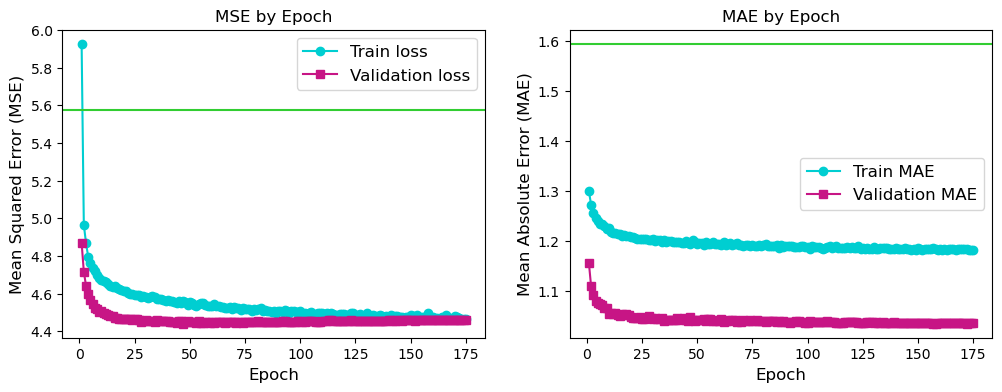

In [180]:
# Don't need this now, but run before submission
create_nn(epoch_count=175)

### Lag Length

In [181]:
def data_prep(lag):
    if lag == 1:
        cols = ['assists_lag_1', 'bonus_lag_1', 'bps_lag_1', 'clean_sheets_lag_1',
           'creativity_lag_1', 'goals_conceded_lag_1', 'goals_scored_lag_1',
           'ict_index_lag_1', 'influence_lag_1', 'minutes_lag_1',
           'own_goals_lag_1', 'penalties_missed_lag_1', 'penalties_saved_lag_1',
           'red_cards_lag_1', 'saves_lag_1', 'selected_lag_1',
           'player_team_score_lag_1', 'opp_team_score_lag_1', 'threat_lag_1',
           'total_points_lag_1', 'value_lag_1', 'yellow_cards_lag_1']
    
    elif lag == 3:
        cols = ['assists_lag_3', 'bonus_lag_3', 'bps_lag_3', 'clean_sheets_lag_3',
               'creativity_lag_3', 'goals_conceded_lag_3', 'goals_scored_lag_3',
               'ict_index_lag_3', 'influence_lag_3', 'minutes_lag_3',
               'own_goals_lag_3', 'penalties_missed_lag_3', 'penalties_saved_lag_3',
               'red_cards_lag_3', 'saves_lag_3', 'selected_lag_3',
               'player_team_score_lag_3', 'opp_team_score_lag_3', 'threat_lag_3',
               'total_points_lag_3', 'value_lag_3', 'yellow_cards_lag_3']
        
    elif lag == 5:
        cols = ['assists_lag_5', 'bonus_lag_5', 'bps_lag_5', 'clean_sheets_lag_5',
           'creativity_lag_5', 'goals_conceded_lag_5', 'goals_scored_lag_5',
           'ict_index_lag_5', 'influence_lag_5', 'minutes_lag_5',
           'own_goals_lag_5', 'penalties_missed_lag_5', 'penalties_saved_lag_5',
           'red_cards_lag_5', 'saves_lag_5', 'selected_lag_5',
           'player_team_score_lag_5', 'opp_team_score_lag_5', 'threat_lag_5',
           'total_points_lag_5', 'value_lag_5', 'yellow_cards_lag_5']
    
    # Making continuous variable tensors
    # Naming convention: "contin" stands for "continuous" and tf signifies that these are tensors
    X_train_contin_tf = tf.convert_to_tensor(X_train[cols])
    X_val_contin_tf = tf.convert_to_tensor(X_val[cols])
    X_test_contin_tf = tf.convert_to_tensor(X_test[cols])
    
    # Making lists of train, val, and test tensors to combine
    # Note: using this method (rather than pytorch) because pytorch kept crashing my kernel
    X_train_tensor_list = [season_train, player_team_name_train, opp_team_name_train, opp_diff_ind_train, 
                           position_train, gw_train, was_home_train, X_train_contin_tf]
    
    X_val_tensor_list = [season_val, player_team_name_val, opp_team_name_val, opp_diff_ind_val, 
                         position_val, gw_val, was_home_val, X_val_contin_tf]
    
    X_test_tensor_list = [season_test, player_team_name_test, opp_team_name_test, opp_diff_ind_test, 
                          position_test, gw_test, was_home_test, X_test_contin_tf]
    
    # Concatenating input tensors
    X_train_tf = tf.keras.layers.Concatenate(axis=1)(X_train_tensor_list)
    X_val_tf = tf.keras.layers.Concatenate(axis=1)(X_val_tensor_list)
    X_test_tf = tf.keras.layers.Concatenate(axis=1)(X_test_tensor_list)
    
    # Making target tensors
    Y_train_tf = tf.convert_to_tensor(Y_train)
    Y_val_tf = tf.convert_to_tensor(Y_val)
    Y_test_tf = tf.convert_to_tensor(Y_test)

In [182]:
# Making a DF in which to store results
lag_results = pd.DataFrame(columns=['lag', 'learning_rate', 'epoch_count', 'hidden_layer_count', 'hidden_layer_size_s', 
                                'hl_act_func', 'dropout_rate', 'oput_act_func', 'optimizer', 'lr_schedule',
                                'decay_steps', 'decay_rate', 'train_loss', 'train_mae','val_loss','val_mae'])

In [183]:
# Setup for testing different configurations

def create_nn(learning_rate=0.00001, epoch_count=20, hidden_layer_sizes=[150, 75], 
              hl_act_func='relu', dropout_rate=0.1, oput_act_func='relu', optimizer='Adam', plot_flag=True,
              verbosity_flag=False, lr_sched='yes', decay_steps=10000, decay_rate=0.95, lag=3):
    
    ############################################################################################## 1
    # Preparing data
    data_prep(lag)
    
    # Getting number of features
    num_features = X_train_tf.shape[1]

    ############################################################################################## 2
    # Building the model
    tf.keras.backend.clear_session()
    model = tf.keras.Sequential()

    # Create input layer
    model.add(tf.keras.Input(shape=(num_features,), name='Input'
              ))

    # Create hidden layers
    for i, hidden_layer_size in enumerate(hidden_layer_sizes):
      model.add(tf.keras.layers.Dense(units=hidden_layer_size,
                                     activation=hl_act_func,
                                     name = f'Hidden_{i+1}'))
    
      # Create dropout after each hidden layer
      model.add(tf.keras.layers.Dropout(rate=dropout_rate, name=f'Dropout_{i+1}') # Need to make dropout rate variable
              )
    
    
    # Create output layer
    model.add(tf.keras.layers.Dense(
              activation = oput_act_func, 
              units = 1,                
              use_bias = True
              ))

    # Set a learning rate schedule
    if lr_sched == 'yes':
        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=learning_rate,
            decay_steps=decay_steps,
            decay_rate=decay_rate)
    else:
        lr_schedule = learning_rate
    
    # Set optimizer
    if optimizer == 'SGD':
      opt = tf.keras.optimizers.SGD(learning_rate=lr_schedule)
    elif optimizer == 'Adam':
      opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
    else:
      raise 'Unsupported optimizer: %s' %optimizer

    ############################################################################################## 3
    # Compiling the model
    model.compile(
        optimizer=opt,
        loss='mse',
        metrics=[metrics.mse,
                 metrics.RootMeanSquaredError(),
                 metrics.mae]
        )

    ############################################################################################## 4
    # Fitting the model
    history = model.fit(
        x = X_train_tf,
        y = Y_train_tf,
        epochs = epoch_count,
        validation_data = (X_val_tf, Y_val_tf),
        verbose=verbosity_flag,
        callbacks=[TqdmCallback()]
    )

    ############################################################################################## 5
    # Displaying learning rates
    if plot_flag == True:
        mse_mae_plots(history)

    ############################################################################################## 6
    # Appending results to the results DF

    # Pulling this in to get loss and accuracy
    hist = history.history
    
    new_row = {'lag':lag, 'learning_rate': learning_rate, 'epoch_count': epoch_count, 'optimizer': optimizer, 'lr_schedule':lr_sched, 
               'decay_steps': decay_steps, 'decay_rate': decay_rate, 'hidden_layer_count': len(hidden_layer_sizes), 
               'hidden_layer_size_s': hidden_layer_sizes, 'hl_act_func': hl_act_func, 'dropout_rate':dropout_rate, 
               'oput_act_func': oput_act_func,'optimizer': optimizer,'train_loss': hist['loss'][-1], 
               'train_mae': hist['mean_absolute_error'][-1], 'val_loss': hist['val_loss'][-1], 
               'val_mae': hist['val_mean_absolute_error'][-1]}
    
    lag_results.loc[len(lag_results)] = new_row

    return history

    ############################################################################################## 7
    # Evaluating the model
    #ffnn_results = model.evaluate(X_test_tf, Y_test_tf)
    #print(f'MSE is {round(ffnn_results[1],3)}')
    #print(f'RMSE is {round(ffnn_results[2],3)}')
    #print(f'MAE is {round(ffnn_results[3],3)}')

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

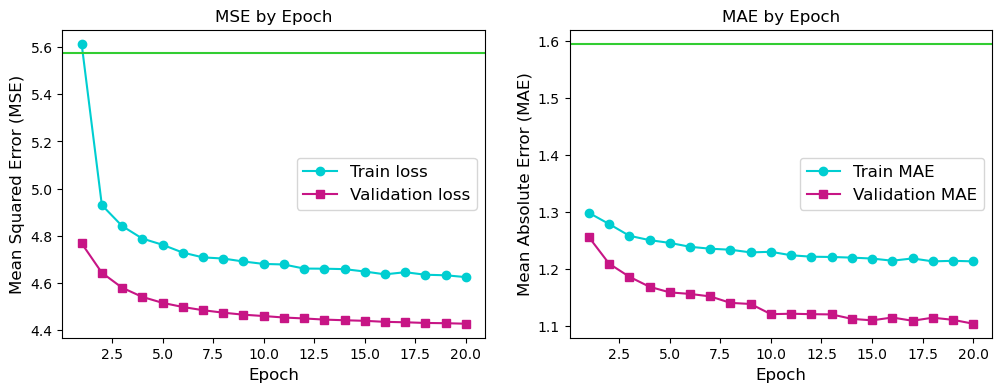

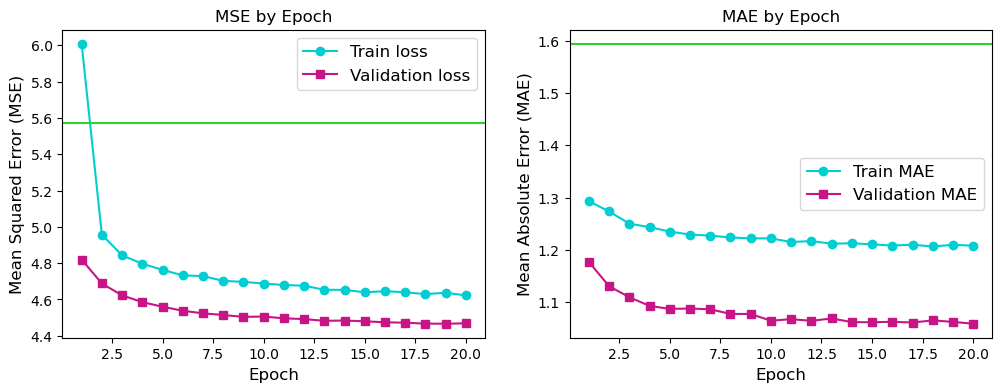

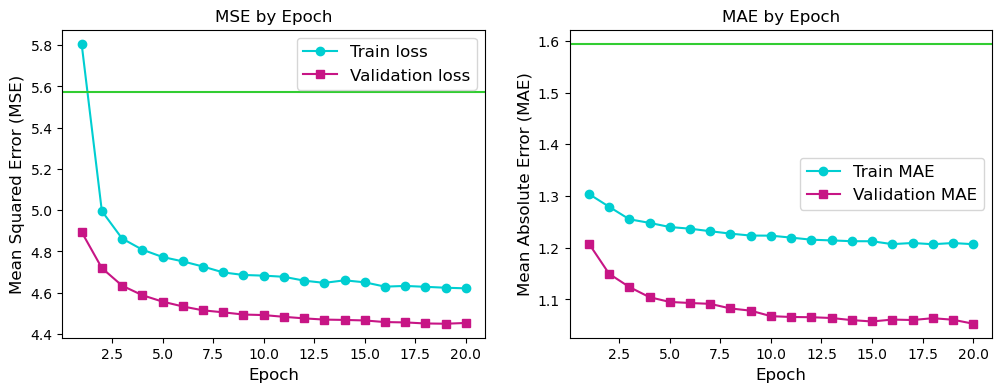

In [184]:
# Lowest LR
hist1 = create_nn(epoch_count=20, lag=1).history
lr1_arr = np.arange(len(hist1['loss'])) + 1

# Middle LR
hist2 = create_nn(epoch_count=20, lag=3).history
lr2_arr = np.arange(len(hist2['loss'])) + 1

# Highest LR
hist3 = create_nn(epoch_count=20, lag=5).history
lr3_arr = np.arange(len(hist3['loss'])) + 1

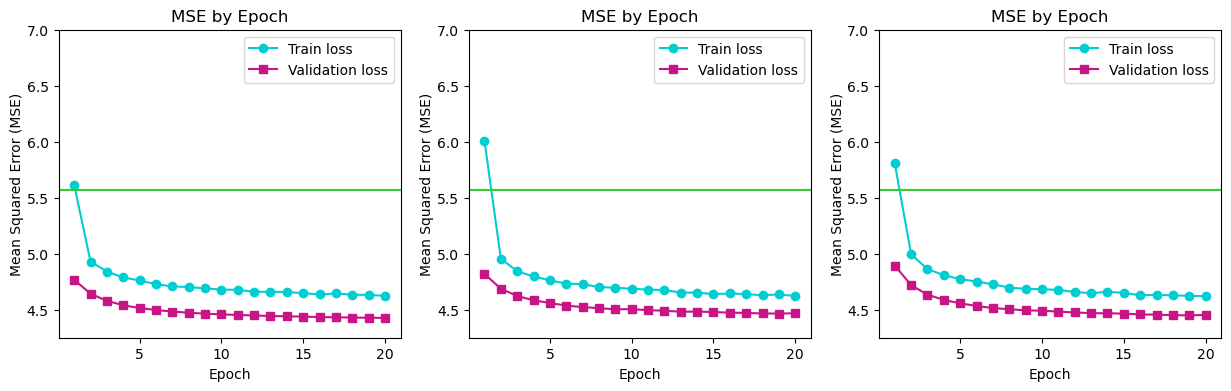

In [185]:
fig = plt.figure(figsize=(15, 4))
count = 1

for arr, hist in zip([lr1_arr, lr2_arr, lr3_arr], [hist1, hist2, hist3]):
    ax = fig.add_subplot(1, 3, count)
    ax.plot(arr, hist['loss'], '-o', color='darkturquoise', label='Train loss')
    ax.plot(arr, hist['val_loss'], '-s', color='mediumvioletred', label='Validation loss')
    plt.axhline(y = MSE(true, pred), color = 'limegreen', linestyle = '-') # Adding a horizontal line for baseline MSE
    ax.legend(fontsize=10)
    ax.set_xlabel('Epoch', size=10)
    ax.set_ylabel('Mean Squared Error (MSE)', size=10, labelpad=2)
    ax.set_title('MSE by Epoch')
    ax.set_ylim([4.25, 7])
    count += 1

# Final evaluation

In [186]:
# Setup for testing different configurations

def create_nn(learning_rate=0.00001, epoch_count=175, hidden_layer_sizes=[150, 75], 
              hl_act_func='relu', dropout_rate=0.1, oput_act_func='relu', optimizer='Adam', plot_flag=True,
              verbosity_flag=False, lr_sched='yes', decay_steps=10000, decay_rate=0.95, lag=5):
    
    ############################################################################################## 1
    # Preparing data
    data_prep(lag)
    
    # Getting number of features
    num_features = X_train_tf.shape[1]

    ############################################################################################## 2
    # Building the model
    tf.keras.backend.clear_session()
    model = tf.keras.Sequential()

    # Create input layer
    model.add(tf.keras.Input(shape=(num_features,), name='Input'
              ))

    # Create hidden layers
    for i, hidden_layer_size in enumerate(hidden_layer_sizes):
      model.add(tf.keras.layers.Dense(units=hidden_layer_size,
                                     activation=hl_act_func,
                                     name = f'Hidden_{i+1}'))
    
      # Create dropout after each hidden layer
      model.add(tf.keras.layers.Dropout(rate=dropout_rate, name=f'Dropout_{i+1}') # Need to make dropout rate variable
              )
    
    
    # Create output layer
    model.add(tf.keras.layers.Dense(
              activation = oput_act_func, 
              units = 1,                
              use_bias = True
              ))

    # Set a learning rate schedule
    if lr_sched == 'yes':
        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=learning_rate,
            decay_steps=decay_steps,
            decay_rate=decay_rate)
    else:
        lr_schedule = learning_rate
    
    # Set optimizer
    if optimizer == 'SGD':
      opt = tf.keras.optimizers.SGD(learning_rate=lr_schedule)
    elif optimizer == 'Adam':
      opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
    else:
      raise 'Unsupported optimizer: %s' %optimizer

    ############################################################################################## 3
    # Compiling the model
    model.compile(
        optimizer=opt,
        loss='mse',
        metrics=[metrics.mse,
                 metrics.RootMeanSquaredError(),
                 metrics.mae]
        )

    ############################################################################################## 4
    # Fitting the model
    history = model.fit(
        x = X_train_tf,
        y = Y_train_tf,
        epochs = epoch_count,
        validation_data = (X_val_tf, Y_val_tf),
        verbose=verbosity_flag,
        callbacks=[TqdmCallback()]
    )

    ############################################################################################## 5
    # Displaying learning rates
    if plot_flag == True:
        mse_mae_plots(history)

    ############################################################################################## 6
    # Appending results to the results DF

    # Pulling this in to get loss and accuracy
    hist = history.history
    
    new_row = {'lag':lag, 'learning_rate': learning_rate, 'epoch_count': epoch_count, 'optimizer': optimizer, 'lr_schedule':lr_sched, 
               'decay_steps': decay_steps, 'decay_rate': decay_rate, 'hidden_layer_count': len(hidden_layer_sizes), 
               'hidden_layer_size_s': hidden_layer_sizes, 'hl_act_func': hl_act_func, 'dropout_rate':dropout_rate, 
               'oput_act_func': oput_act_func,'optimizer': optimizer,'train_loss': hist['loss'][-1], 
               'train_mae': hist['mean_absolute_error'][-1], 'val_loss': hist['val_loss'][-1], 
               'val_mae': hist['val_mean_absolute_error'][-1]}
    
    lag_results.loc[len(lag_results)] = new_row

    return model

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

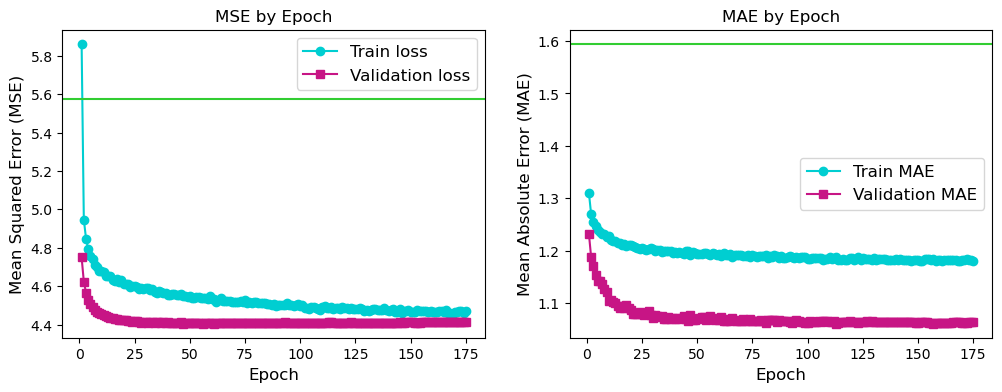

In [187]:
final_model = create_nn()

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

829/829 [==============================] - 0s 504us/step - loss: 3.9847 - mean_squared_error: 3.9847 - root_mean_squared_error: 1.9962 - mean_absolute_error: 1.0887
MSE is 3.985
RMSE is 1.996
MAE is 1.089


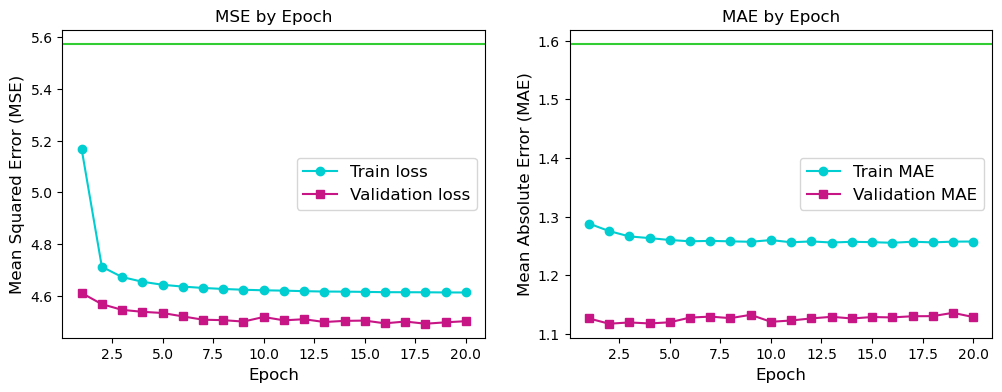

In [188]:
make_lin_reg_model(learning_rate=0.0005, optimizer='Adam', epoch_count=20, lr_sched='yes', decay_steps=10000, decay_rate=0.9)

In [189]:
ffnn_results = final_model.evaluate(X_test_tf, Y_test_tf)
print(f'MSE is {round(ffnn_results[1],3)}')
print(f'RMSE is {round(ffnn_results[2],3)}')
print(f'MAE is {round(ffnn_results[3],3)}')

829/829 [==============================] - 0s 539us/step - loss: 3.9661 - mean_squared_error: 3.9661 - root_mean_squared_error: 1.9915 - mean_absolute_error: 1.1161
MSE is 3.966
RMSE is 1.992
MAE is 1.116
